In [2]:
pip install numpy


  Using cached numpy-2.2.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.3-cp311-cp311-win_amd64.whl (12.9 MB)


In [4]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tensorflow

  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.70.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB

  You can safely remove it manually.
  You can safely remove it manually.


In [8]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl (41.2 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dropout, Dense, Multiply, Add
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical


In [2]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-6
PATIENCE = 2
FACTOR = 0.5
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = "categorical_crossentropy"

# Paths
data_dir = "./D2"

# Apply Gamma Correction
def apply_gamma_correction(image, gamma=1.5):
    image = (image * 255).astype("uint8")  # Convert to uint8
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    corrected_image = cv2.LUT(image, table)
    return corrected_image.astype("float32") / 255.0  # Convert back to float32 (0-1 range)

# Apply Cutout
def cutout(image, mask_size=50):
    h, w, _ = image.shape
    y, x = np.random.randint(h), np.random.randint(w)
    y1, y2 = np.clip([y - mask_size // 2, y + mask_size // 2], 0, h)
    x1, x2 = np.clip([x - mask_size // 2, x + mask_size // 2], 0, w)
    image[y1:y2, x1:x2, :] = 0
    return image

# Apply MixUp
def mixup(image1, image2, label1, label2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    mixed_image = lam * image1 + (1 - lam) * image2
    mixed_label = lam * label1 + (1 - lam) * label2
    return mixed_image, mixed_label

# Apply CutMix
def cutmix(image1, image2, label1, label2):
    h, w, _ = image1.shape
    lam = np.random.beta(1.0, 1.0)
    cx, cy = np.random.randint(w), np.random.randint(h)
    bw, bh = int(w * np.sqrt(1 - lam)), int(h * np.sqrt(1 - lam))
    x1, y1 = max(cx - bw // 2, 0), max(cy - bh // 2, 0)
    x2, y2 = min(cx + bw // 2, w), min(cy + bh // 2, h)
    image1[y1:y2, x1:x2, :] = image2[y1:y2, x1:x2, :]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (h * w))
    mixed_label = lam * label1 + (1 - lam) * label2
    return image1, mixed_label

# Load and augment dataset
def load_data_with_augmentations(data_dir):
    images, labels = [], []
    class_names = os.listdir(data_dir)

    for label, class_dir in enumerate(class_names):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        image_list = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE) / 255.0
            images.append(img)
            labels.append(label)
            image_list.append(img)

        # Apply Cutout & Gamma Correction
        for img in image_list:
            images.append(cutout(img.copy()))
            labels.append(label)
            images.append(apply_gamma_correction(img.copy()))
            labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(class_names))

    # Apply MixUp and CutMix
    augmented_images, augmented_labels = [], []
    for i in range(len(images) - 1):
        img1, img2 = images[i], images[i + 1]
        lbl1, lbl2 = labels[i], labels[i + 1]
        mixup_img, mixup_lbl = mixup(img1, img2, lbl1, lbl2)
        cutmix_img, cutmix_lbl = cutmix(img1, img2, lbl1, lbl2)
        augmented_images.extend([mixup_img, cutmix_img])
        augmented_labels.extend([mixup_lbl, cutmix_lbl])

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    images = np.concatenate([images, augmented_images], axis=0)
    labels = np.concatenate([labels, augmented_labels], axis=0)

    return images, labels

In [3]:
# Load dataset with augmentations
X, y = load_data_with_augmentations(data_dir)

In [4]:
# Train/Validation/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [5]:
def attention_module(x):
    attention = Dense(x.shape[-1], activation='sigmoid')(x)
    return Multiply()([x, attention])


# Define feature extraction models
def create_model(base_model, input_shape, dropout_rate=0.4):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)
    x = attention_module(x)  # Apply attention
    return Model(inputs=base.input, outputs=x)


input_shape = (224, 224, 3)
model_DenseNet201 = create_model(DenseNet201, input_shape)
model_InceptionV3 = create_model(InceptionV3, input_shape)
model_Xception = create_model(Xception, input_shape)
model_ResNet50V2 = create_model(ResNet50V2, input_shape)



# Feature extraction in batches
def extract_features_in_batches(model, data, batch_size=32):
    features = []
    for start in range(0, len(data), batch_size):
        end = start + batch_size
        batch_data = data[start:end]
        batch_tensor = tf.convert_to_tensor(batch_data, dtype=tf.float32)
        batch_features = model.predict(batch_tensor)  # Updated to use .predict()
        features.append(batch_features)
    return np.vstack(features)


In [6]:
# Extract features for training
features_DenseNet201 = extract_features_in_batches(model_DenseNet201, X_train, batch_size=BATCH_SIZE)
features_InceptionV3 = extract_features_in_batches(model_InceptionV3, X_train, batch_size=BATCH_SIZE)
features_Xception = extract_features_in_batches(model_Xception, X_train, batch_size=BATCH_SIZE)
features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, X_train, batch_size=BATCH_SIZE)


# Combine extracted features
X_train_features = np.concatenate([features_DenseNet201, features_InceptionV3, features_Xception, features_ResNet50V2], axis=1)

c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_710']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_710']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1024']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1024']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1159']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1

c:\Users\DELL\Documents\PFE\M2\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1159']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [7]:
# Extract features for validation
features_DenseNet201_val = extract_features_in_batches(model_DenseNet201, X_val, batch_size=BATCH_SIZE)
features_InceptionV3_val = extract_features_in_batches(model_InceptionV3, X_val, batch_size=BATCH_SIZE)
features_Xception_val = extract_features_in_batches(model_Xception, X_val, batch_size=BATCH_SIZE)
features_ResNet50V2_val = extract_features_in_batches(model_ResNet50V2, X_val, batch_size=BATCH_SIZE)


X_val_features = np.concatenate([features_DenseNet201_val, features_InceptionV3_val, features_Xception_val, features_ResNet50V2_val], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [8]:
# Extract features for testing

features_DenseNet201_test = extract_features_in_batches(model_DenseNet201, X_test, batch_size=BATCH_SIZE)
features_InceptionV3_test = extract_features_in_batches(model_InceptionV3, X_test, batch_size=BATCH_SIZE)
features_Xception_test = extract_features_in_batches(model_Xception, X_test, batch_size=BATCH_SIZE)
features_ResNet50V2_test = extract_features_in_batches(model_ResNet50V2, X_test, batch_size=BATCH_SIZE)


X_test_features = np.concatenate([features_DenseNet201_test, features_InceptionV3_test, features_Xception_test, features_ResNet50V2_test], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [9]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# 1️⃣ Définir les hyperparamètres à tester pour chaque modèle
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 5, 10]
}

dt_params = {
    "max_depth": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 5]
}

mlp_params = {
    "hidden_layer_sizes": [(50,), (100, 50), (100,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate": ["constant", "adaptive"]
}


In [10]:

# 2️⃣ Recherche des meilleurs hyperparamètres avec GridSearchCV
print("Optimisation du RandomForest...")
rf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=1), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train_features, np.argmax(y_train, axis=1))
best_rf = rf.best_estimator_
print("Meilleurs paramètres RF:", rf.best_params_)



Optimisation du RandomForest...
Meilleurs paramètres RF: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [11]:
print("Optimisation du DecisionTree...")
dt = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=0), dt_params, cv=3, n_jobs=-1)
dt.fit(X_train_features, np.argmax(y_train, axis=1))
best_dt = dt.best_estimator_
print("Meilleurs paramètres DT:", dt.best_params_)


Optimisation du DecisionTree...
Meilleurs paramètres DT: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1}


In [12]:
print("Optimisation du MLP...")
mlp = GridSearchCV(MLPClassifier(max_iter=600, random_state=42), mlp_params, cv=3, n_jobs=-1)
mlp.fit(X_train_features, np.argmax(y_train, axis=1))
best_mlp = mlp.best_estimator_
print("Meilleurs paramètres MLP:", mlp.best_params_)


Optimisation du MLP...
Meilleurs paramètres MLP: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [13]:
ensemble_model = VotingClassifier(estimators=[("RF", best_rf), ("DT", best_dt), ("MLP", best_mlp)], voting="hard",
                                   weights=[1, 2, 3], n_jobs=-1, verbose=2, flatten_transform=True)

# Entraîner le modèle
ensemble_model.fit(X_train_features, np.argmax(y_train, axis=1))

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=1)),
                             ('DT',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=50,
                                                     random_state=0)),
                             ('MLP',
                              MLPClassifier(max_iter=600, random_state=42))],
                 n_jobs=-1, verbose=2, weights=[1, 2, 3])

In [14]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=[("RF", best_rf), ("DT", best_dt), ("MLP", best_mlp)], final_estimator=meta_model,
                                     passthrough=True, n_jobs=-1)

# Entraîner le modèle de stacking
stacking_model.fit(X_train_features, np.argmax(y_train, axis=1))


StackingClassifier(estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=1)),
                               ('DT',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=50,
                                                       random_state=0)),
                               ('MLP',
                                MLPClassifier(max_iter=600, random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [15]:
# Validate ensemble model
y_val_pred = stacking_model.predict(X_val_features)

val_acc = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {val_acc}")


Validation Accuracy: 0.9876989869753979


In [16]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
# Test ensemble model
y_test_pred = stacking_model.predict(X_test_features)
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       679
           1       0.99      0.99      0.99       703

    accuracy                           0.99      1382
   macro avg       0.99      0.99      0.99      1382
weighted avg       0.99      0.99      0.99      1382

Test Accuracy: 0.9913169319826338


In [18]:
pip install matplotlib


  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


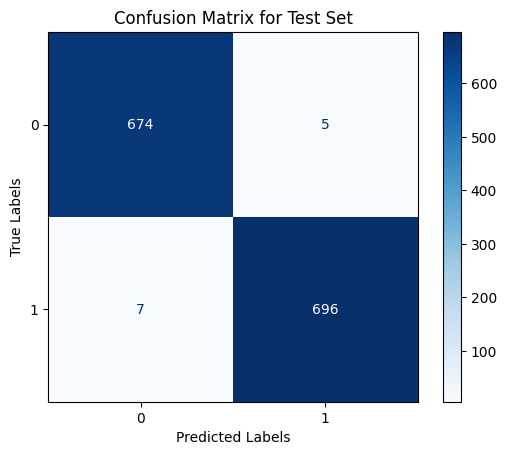

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(np.argmax(y_test, axis=1)))
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix for Test Set")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()


In [30]:
import cv2
import numpy as np

# Charger et prétraiter l'image de test
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {image_path}")
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisation
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour le batch
    return img

# Chemin de l'image de test
test_image_path = "test.jpg"

# Prétraitement de l'image
test_image = preprocess_image(test_image_path)

# Extraction des caractéristiques pour chaque modèle
test_features_DenseNet201 = extract_features_in_batches(model_DenseNet201, test_image, batch_size=1)
test_features_InceptionV3 = extract_features_in_batches(model_InceptionV3, test_image, batch_size=1)
test_features_Xception = extract_features_in_batches(model_Xception, test_image, batch_size=1)
test_features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, test_image, batch_size=1)

# Combiner les caractéristiques extraites
X_test_image_features = np.concatenate(
    [test_features_DenseNet201, test_features_InceptionV3, test_features_Xception, test_features_ResNet50V2], axis=1
)

# Prédiction avec le modèle d'ensemble
predicted_class = ensemble_model.predict(X_test_image_features)
print("Classe prédite :", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Classe prédite : [1]


In [21]:
import joblib

# Save the classifier
joblib.dump(ensemble_model, "M2.pkl")

['M2.pkl']

In [31]:
import joblib
import cv2
import numpy as np

# Charger le modèle d'ensemble
ensemble_model = joblib.load("M2.pkl")

# Fonction de prétraitement de l'image
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {image_path}")
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisation
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour le batch
    return img

# Charger et prétraiter l'image de test
test_image_path = "test.jpg"
test_image = preprocess_image(test_image_path)

# Extraction des caractéristiques (assurez-vous que ces modèles sont définis et chargés)
test_features_DenseNet201 = extract_features_in_batches(model_DenseNet201, test_image, batch_size=1)
test_features_InceptionV3 = extract_features_in_batches(model_InceptionV3, test_image, batch_size=1)
test_features_Xception = extract_features_in_batches(model_Xception, test_image, batch_size=1)
test_features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, test_image, batch_size=1)

# Combinaison des caractéristiques extraites
X_test_image_features = np.concatenate(
    [test_features_DenseNet201, test_features_InceptionV3, test_features_Xception, test_features_ResNet50V2], axis=1
)

# Prédiction avec le modèle d'ensemble
predicted_class = ensemble_model.predict(X_test_image_features)
print("Classe prédite :", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Classe prédite : [1]


In [4]:
import joblib
import cv2
import numpy as np
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dropout, Dense, Multiply, Add
import tensorflow as tf

# Load the ensemble model
ensemble_model = joblib.load("M2.pkl")

# Class mapping
class_labels = {0: "Not Rust Disease", 1: "Rust Disease"}

# Function to preprocess the image
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {image_path}")
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalization
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img
def attention_module(x):
    attention = Dense(x.shape[-1], activation='sigmoid')(x)
    return Multiply()([x, attention])


# Define feature extraction models
def create_model(base_model, input_shape, dropout_rate=0.4):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)
    x = attention_module(x)  # Apply attention
    return Model(inputs=base.input, outputs=x)


input_shape = (224, 224, 3)
model_DenseNet201 = create_model(DenseNet201, input_shape)
model_InceptionV3 = create_model(InceptionV3, input_shape)
model_Xception = create_model(Xception, input_shape)
model_ResNet50V2 = create_model(ResNet50V2, input_shape)



# Feature extraction in batches
def extract_features_in_batches(model, data, batch_size=32):
    features = []
    for start in range(0, len(data), batch_size):
        end = start + batch_size
        batch_data = data[start:end]
        batch_tensor = tf.convert_to_tensor(batch_data, dtype=tf.float32)
        batch_features = model.predict(batch_tensor)  # Updated to use .predict()
        features.append(batch_features)
    return np.vstack(features)


# Load and preprocess the test image
test_image_path = "test.jpg"
test_image = preprocess_image(test_image_path)

# Feature extraction (ensure models are defined and loaded)
test_features_DenseNet201 = extract_features_in_batches(model_DenseNet201, test_image, batch_size=1)
test_features_InceptionV3 = extract_features_in_batches(model_InceptionV3, test_image, batch_size=1)
test_features_Xception = extract_features_in_batches(model_Xception, test_image, batch_size=1)
test_features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, test_image, batch_size=1)

# Combine extracted features
X_test_image_features = np.concatenate(
    [test_features_DenseNet201, test_features_InceptionV3, test_features_Xception, test_features_ResNet50V2], axis=1
)

# Predict with the ensemble model
predicted_class = ensemble_model.predict(X_test_image_features)[0]  # Get the first prediction
predicted_label = class_labels.get(predicted_class, "Unknown")  # Map to label

print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)


c:\Users\DELL\Documents\PFE\M1\venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1352']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


c:\Users\DELL\Documents\PFE\M1\venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2062']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


c:\Users\DELL\Documents\PFE\M1\venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2376']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


c:\Users\DELL\Documents\PFE\M1\venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2511']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: 1
Predicted Label: Rust Disease
